# Geodesic Runtime

In [1]:
import jax.numpy as jnp

import os

import pickle

from typing import List

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from tabulate import tabulate

In [2]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
device = 'gpu'
geometry = "riemannian"
batch_size = '10'
path = f'timing_{device}/{geometry}/'
manifold = "Sphere"
figure_path = '../figures/frechet_runtime/'

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading Values

In [5]:
def load_estimates(path:str, manifold:str, batch_size:int):
    
    save_path = ''.join((path, manifold, '/'))
    
    onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
    onlyfiles = [f for f in onlyfiles if f'batch={batch_size}.pkl' in f]
    
    estimates = {}
    for file in onlyfiles:
        file_path = ''.join((save_path, file))
        with open(file_path, 'rb') as f:
            values = pickle.load(f)
        method = file.split(f'_{manifold}')[0]
        dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_batch={batch_size}', '')
        if dim in estimates:
            estimates[dim] = dict(estimates[dim], **values)
        else:
            estimates[dim] = values
            
    return estimates
    
    

In [6]:
estimates = load_estimates(path, manifold, batch_size)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Table Comparison

In [7]:
dims = list(estimates.keys())

mu_time = [estimates[key3][key2]['mu_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
std_time = [estimates[key3][key2]['std_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
sum_geodesic_dist = [estimates[key3][key2]['sum_geodesic_dist'] for key3,v3 in estimates.items()for key2,v2 in v3.items()]
iter_num = [estimates[key3][key2]['iterations'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
grad_norm = [estimates[key3][key2]['grad_norm'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
error = []
for key3, v3 in estimates.items():
    for key2, v2 in v3.items():
        val = estimates[key3][key2]
        if "error" in val.keys():
            error.append(val['error'])
        else:
            error.append(None)
max_iter = [estimates[key3][key2]['max_iter'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
tol = [estimates[key3][key2]['tol'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
method = [key2 for key3,v3 in estimates.items() for key2,v2 in v3.items()]
dims = [key3 for key3,v3 in estimates.items() for key2,v2 in v3.items()]

N_methods = len(list(set(method)))
#dims = sum([[d]*N_methods for d in dims], [])

In [8]:
names = [r"Dim", r"Method", #r"Error",
        r"Geo Sq. Dist", r"Iterations", r"grad_norm", r"mean time",
        r"std time", r"max_iter", r"tol"]

table_dict = {}
table_dict['Dim'] = dims
table_dict['Method'] = method
table_dict['sum_geodesic_dist'] = sum_geodesic_dist
table_dict['Iterations'] = iter_num
table_dict['grad_norm'] = grad_norm
table_dict['mu_time'] = mu_time
table_dict['std_time'] = std_time
table_dict['max_iter'] = max_iter
table_dict['tol'] = tol

print(tabulate(table_dict, headers=names, floatfmt=".4f"))


  Dim  Method              Geo Sq. Dist    Iterations    grad_norm    mean time    std time    max_iter     tol
-----  ----------------  --------------  ------------  -----------  -----------  ----------  ----------  ------
   50  Euclidean                64.5898
   50  adam                     15.6994     1000.0000       0.0023      22.8670      0.0126        1000  0.0001
   50  GEORCE_FM                 6.6726        3.0000       0.0000       0.3804      0.0002        1000  0.0001
   50  sgd                      64.2190     1000.0000       0.0322      22.6515      0.0013        1000  0.0001
   50  adamax                   27.9952     1000.0000       0.0133      22.7582      0.0012        1000  0.0001
   50  rmsprop_momentum          9.1358     1000.0000       0.0032      23.8358      0.0063        1000  0.0001
   50  adagrad                  26.5694     1000.0000       0.0088      22.7203      0.0073        1000  0.0001
   50  rmsprop                  19.2082     1000.0000       0.18

### Printing Table Version of Table

In [9]:
def manifold_str(m, d):
    
    if m == "Sphere":
        return "$\mathbb{S}^{"+f"{d}"+"}$"
    elif m == "Ellipsoid":
        return "$\mathrm{E}\\left( "+f"{d}"+" \\right)$"
    elif m == "SPDN":
        return "$\mathcal{P}\\left( "+f"{d}"+" \\right)$"
    elif m == "T2":
        return "$\mathbb{T}^{"+f"{d}"+"}$"
    elif m == "H2":
        return "$\mathbb{H}^{"+f"{d}"+"}$"
    elif m == "HyperbolicParaboloid":
        return "Hyperbolic Paraboloid"
    elif m == "Gaussian":
        return "Gaussian Distribution"
    elif m == "Frechet":
        return "Fr\\'echet Distribution"
    elif m == "Cauchy":
        return "Cauchy Distribution"
    elif m == "Pareto":
        return "Pareto Distribution"
    elif m == "mnist":
        return "VAE MNIST"
    elif m == "celeba":
        return "VAE CelebA"
    else:
        return m

In [10]:
def print_runtimes(path:str, manifolds:List, batch_size:int, methods:List, display_iter:bool = False):
    
    
    for man in manifolds:
        
        estimates = load_estimates(path, man, batch_size)
    
        dims = [int(key3) for key3, v3 in estimates.items()]
        dims.sort()
        dims = [str(d) for d in dims]

        for d in dims:
            print(f"{manifold_str(man,d)}", end="")
            sum_geo_dist = []
            iters = []
            mu_times = []
            std_times = []
            for m in methods:
                if m in estimates[d].keys():
                    sum_geo_dist.append(estimates[d][m]['sum_geodesic_dist'])
                    iters.append(estimates[d][m]['iterations'])
                    mu_times.append(estimates[d][m]['mu_time'])
                    std_times.append(estimates[d][m]['std_time'])
                else:
                    sum_geo_dist.append(jnp.nan)
                    iters.append(jnp.nan)
                    mu_times.append(jnp.nan)
                    std_times.append(jnp.nan)
            sum_geo_dist = jnp.stack(sum_geo_dist)
            iters = jnp.stack(iters)
            mu_times = jnp.stack(mu_times)
            std_times = jnp.stack(std_times)
            best_geo_length = jnp.where(sum_geo_dist == jnp.nanmin(sum_geo_dist))[0]
            best_iters = jnp.where(iters == jnp.nanmin(iters))[0]
            best_times = jnp.where(mu_times == jnp.nanmin(mu_times))[0]
            for i in range(len(sum_geo_dist)):
                if jnp.isnan(sum_geo_dist[i]):
                    l = '-'
                    it = '-'
                    mu_time = '-'
                    std_time = '-'
                    print(f" & ${l}/{l}$", end="")
                    if display_iter:
                        print(f" & ${it}$", end="")
                    print(f" & $-$", end="")
                else:
                    if i in best_geo_length:
                        geo_string = f" & $\\pmb{{{sum_geo_dist[i]:.2f}}}$"
                    else:
                        geo_string = f" & ${sum_geo_dist[i]:.2f}$"
                    print(geo_string, end="")
                    if display_iter:
                        if i in best_iters:
                            print(f" & $\\pmb{{{int(iters[i])}}}$", end="")
                        else:
                            print(f" & ${int(iters[i])}$", end="")
                    if i in best_times:
                        print(f" & $\\pmb{{{mu_times[i]:.4f}}} \pm \\pmb{{ {std_times[i]:.4f} }}$", end="")
                    else:
                        print(f" & ${mu_times[i]:.4f} \pm {std_times[i]:.4f}$", end="")
            print(" \\\ ")
        print("\hline")
    

In [11]:
manifolds = ['Sphere', 'Ellipsoid', 'T2', 'H2', 'Paraboloid', 'HyperbolicParaboloid', 'Gaussian', 'Frechet',
            'Cauchy', 'Pareto', 'mnist', 'celeba']
methods = ['adam', 'rmsprop_momentum', 'GEORCE_FM']
#methods = ["sgd", "rmsprop", "adamax"]
#methods = ["adagrad"]

In [12]:
print_runtimes(path, manifolds, batch_size, methods, display_iter=False)

$\mathbb{S}^{2}$ & $217.60$ & $1.6659 \pm 0.0014$ & $\pmb{202.28}$ & $2.2034 \pm 0.0016$ & $204.99$ & $\pmb{0.0511} \pm \pmb{ 0.0004 }$ \\ 
$\mathbb{S}^{3}$ & $158.24$ & $1.7084 \pm 0.0012$ & $\pmb{133.92}$ & $1.7003 \pm 0.0011$ & $135.98$ & $\pmb{0.0527} \pm \pmb{ 0.0002 }$ \\ 
$\mathbb{S}^{5}$ & $131.77$ & $1.8661 \pm 0.0010$ & $\pmb{85.48}$ & $1.8384 \pm 0.0019$ & $88.01$ & $\pmb{0.0511} \pm \pmb{ 0.0001 }$ \\ 
$\mathbb{S}^{10}$ & $70.37$ & $2.9207 \pm 0.0022$ & $36.79$ & $2.9029 \pm 0.0019$ & $\pmb{35.20}$ & $\pmb{0.0817} \pm \pmb{ 0.0018 }$ \\ 
$\mathbb{S}^{20}$ & $39.04$ & $5.3649 \pm 0.0017$ & $18.83$ & $5.3124 \pm 0.0012$ & $\pmb{16.97}$ & $\pmb{0.1210} \pm \pmb{ 0.0002 }$ \\ 
$\mathbb{S}^{50}$ & $15.70$ & $22.8670 \pm 0.0126$ & $9.14$ & $23.8358 \pm 0.0063$ & $\pmb{6.67}$ & $\pmb{0.3804} \pm \pmb{ 0.0002 }$ \\ 
$\mathbb{S}^{100}$ & $7.64$ & $84.6233 \pm 0.0934$ & $5.80$ & $84.7071 \pm 0.0068$ & $\pmb{3.27}$ & $\pmb{1.5414} \pm \pmb{ 0.0005 }$ \\ 
\hline
$\mathrm{E}\left( 2 \ri

### Printing Adaptive Version of Table

In [13]:
display_iter = False

In [14]:
methods = ['ADAadam', 'ADArmsprop_momentum', 'GEORCE_AdaFM']
#methods = ["ADAsgd", "ADArmsprop", "ADAadamax"]
#methods = ["ADAadagrad"]

In [15]:
def print_adaptive_runtimes(path:str, manifolds:List, batches:List, methods:List, display_iter:bool = False):
    
    for man in manifolds:
        
        estimates_list = []
        for batch_size in batches:
            estimates_list.append(load_estimates(path, man, batch_size))
    
        estimates = estimates_list[0]
        dims = [int(key3) for key3, v3 in estimates.items()]
        dims.sort()
        dims = [str(d) for d in dims]

        for d in dims:
            print(f"{manifold_str(man,d)}", end="")
            for estimates in estimates_list:
                sum_geo_dist = []
                iters = []
                mu_times = []
                std_times = []
                for m in methods:
                    if m in estimates[d].keys():
                        sum_geo_dist.append(estimates[d][m]['sum_geodesic_dist'])
                        iters.append(estimates[d][m]['iterations'])
                        mu_times.append(estimates[d][m]['mu_time'])
                        std_times.append(estimates[d][m]['std_time'])
                    else:
                        sum_geo_dist.append(jnp.nan)
                        iters.append(jnp.nan)
                        mu_times.append(jnp.nan)
                        std_times.append(jnp.nan)
                sum_geo_dist = jnp.stack(sum_geo_dist)
                iters = jnp.stack(iters)
                mu_times = jnp.stack(mu_times)
                std_times = jnp.stack(std_times)
                best_geo_length = jnp.where(sum_geo_dist == jnp.nanmin(sum_geo_dist))[0]
                best_iters = jnp.where(iters == jnp.nanmin(iters))[0]
                best_times = jnp.where(mu_times == jnp.nanmin(mu_times))[0]
                for i in range(len(sum_geo_dist)):
                    if jnp.isnan(sum_geo_dist[i]):
                        l = '-'
                        it = '-'
                        mu_time = '-'
                        std_time = '-'
                        print(f" & ${l}/{l}$", end="")
                        if display_iter:
                            print(f" & ${it}$", end="")
                    else:
                        if i in best_geo_length:
                            geo_string = f" & $\\pmb{{{sum_geo_dist[i]:.2f}}}$"
                        else:
                            geo_string = f" & ${sum_geo_dist[i]:.2f}$"
                        print(geo_string, end="")
                        if display_iter:
                            if i in best_iters:
                                print(f" & $\\pmb{{{int(iters[i])}}}$", end="")
                            else:
                                print(f" & ${int(iters[i])}$", end="")
            print(" \\\ ")
        print("\hline")
    

In [16]:
manifolds = ['Sphere', 'Ellipsoid', 'T2', 'H2', 'Paraboloid', 'HyperbolicParaboloid', 'Gaussian', 'Frechet',
            'Cauchy', 'Pareto', 'mnist', 'celeba']
methods = ['ADAadam', 'ADArmsprop_momentum', 'GEORCE_AdaFM']
#methods = ["ADAsgd", "ADArmsprop", "ADAadamax"]
#methods = ["ADAadagrad"]

In [17]:
print_adaptive_runtimes(path, manifolds, ['005', '01'], methods, display_iter=False)

$\mathbb{S}^{2}$ & $2375.74$ & $\pmb{2181.82}$ & $2203.68$ & $2370.92$ & $\pmb{2033.23}$ & $2179.36$ \\ 
$\mathbb{S}^{3}$ & $2338.46$ & $1498.46$ & $\pmb{1434.05}$ & $2339.52$ & $\pmb{1378.82}$ & $1430.57$ \\ 
$\mathbb{S}^{5}$ & $2024.29$ & $911.91$ & $\pmb{823.87}$ & $2025.96$ & $851.12$ & $\pmb{821.47}$ \\ 
$\mathbb{S}^{10}$ & $1275.88$ & $\pmb{423.88}$ & $-/-$ & $1277.13$ & $394.19$ & $\pmb{374.00}$ \\ 
$\mathbb{S}^{20}$ & $817.73$ & $203.14$ & $\pmb{173.96}$ & $810.52$ & $188.29$ & $\pmb{173.73}$ \\ 
$\mathbb{S}^{50}$ & $394.56$ & $85.54$ & $\pmb{68.91}$ & $378.83$ & $83.76$ & $\pmb{68.82}$ \\ 
$\mathbb{S}^{100}$ & $204.95$ & $51.26$ & $\pmb{33.64}$ & $192.71$ & $51.20$ & $\pmb{33.57}$ \\ 
\hline
$\mathrm{E}\left( 2 \right)$ & $1354.07$ & $1341.27$ & $\pmb{1309.77}$ & $1364.47$ & $1482.42$ & $\pmb{1308.92}$ \\ 
$\mathrm{E}\left( 3 \right)$ & $1445.09$ & $\pmb{1171.52}$ & $1266.38$ & $1446.98$ & $\pmb{846.17}$ & $1163.29$ \\ 
$\mathrm{E}\left( 5 \right)$ & $1334.09$ & $576.19$ & $\p

## Plotting $\mathbb{S}^{n}$ and Ellipsoid(n) for $T=100$

In [18]:
device = 'gpu'
geometry = "riemannian"
batch_size = '10'
path = f'timing_{device}/{geometry}/'
figure_path = '../figures/frechet_runtime/'

In [19]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading $\mathbb{S}^{n}$

In [20]:
manifold = "Sphere"
save_path = ''.join((path, manifold, '/'))

In [21]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'batch={batch_size}.pkl' in f]

In [22]:
sphere_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_batch={batch_size}', '')
    if dim in sphere_estimates:
        sphere_estimates[dim] = dict(sphere_estimates[dim], **values)
    else:
        sphere_estimates[dim] = values

## Loading Ellipsoid(n)

In [23]:
manifold = "Ellipsoid"
save_path = ''.join((path, f"{manifold}", '/'))

In [24]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'batch={batch_size}.pkl' in f]

In [25]:
ellipsoid_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_batch={batch_size}', '')
    if dim in ellipsoid_estimates:
        ellipsoid_estimates[dim] = dict(ellipsoid_estimates[dim], **values)
    else:
        ellipsoid_estimates[dim] = values

## Table Comparison

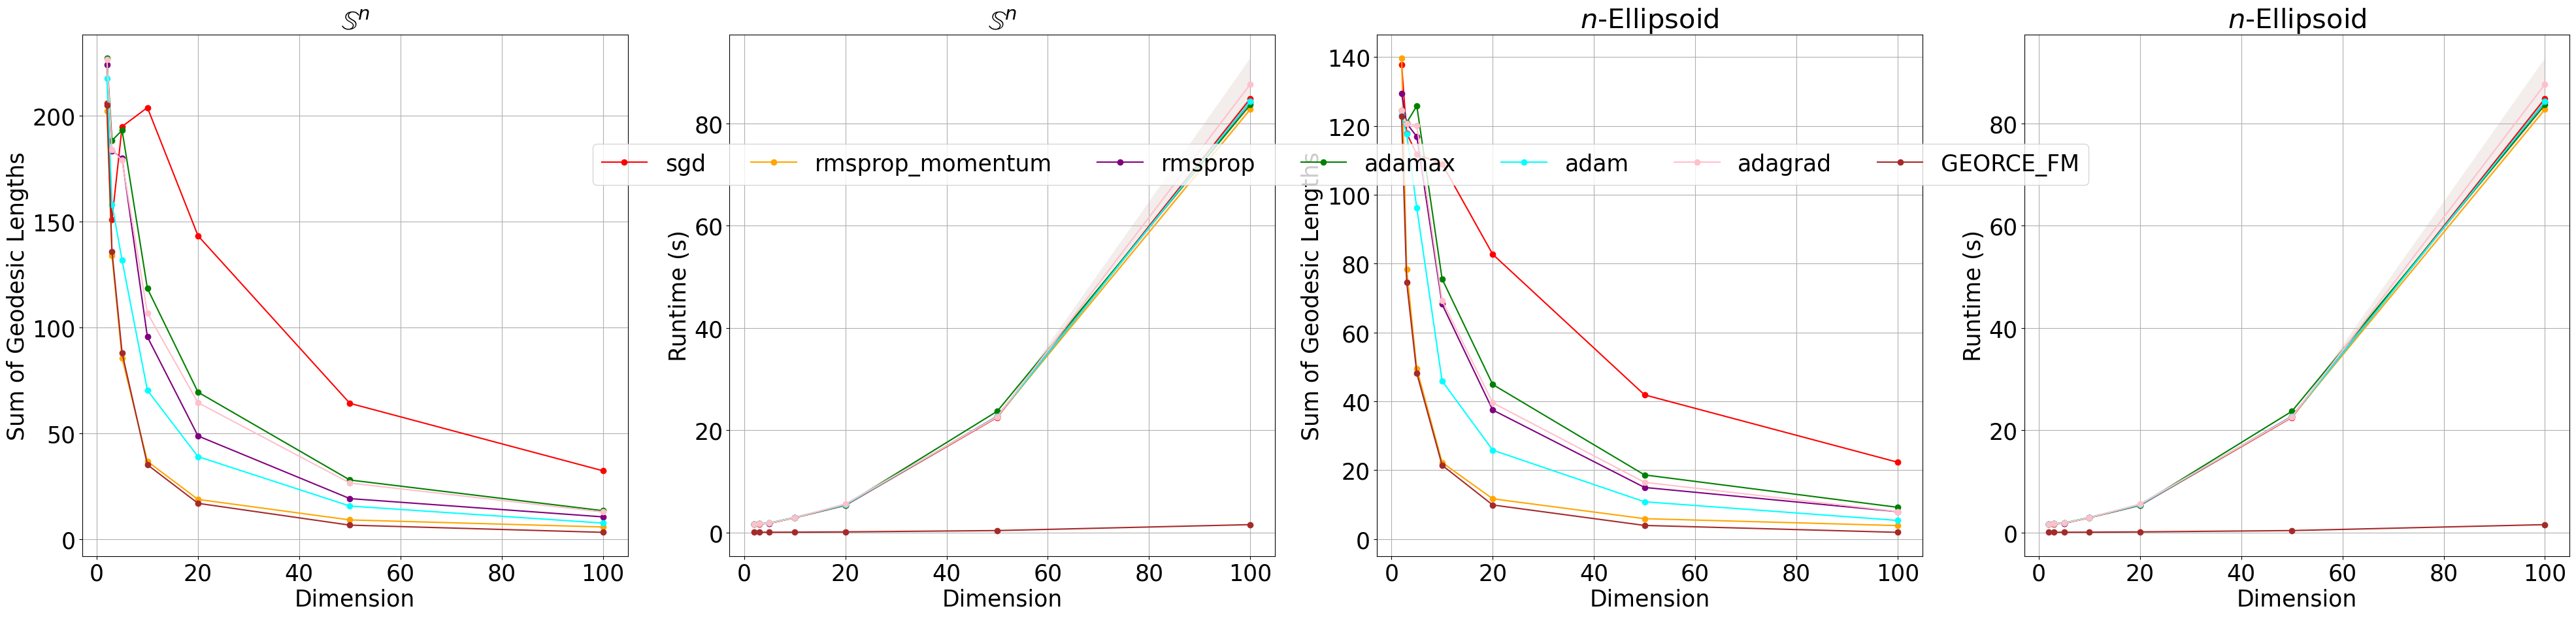

In [26]:
#methods = ['BFGS', 'ADAM', 'GEORCE']
#methods = ['SGD', 'CG', 'dogleg']
#methods = ['trust-ncg', 'trust-exact']

methods = ["sgd", "rmsprop_momentum", "rmsprop", "adamax", "adam", "adagrad", 'GEORCE_FM']
color = ['red', 'orange', 'purple', 'green', 'cyan', 'pink', 'brown', 'blue']
dims = [2,3,5,10,20,50,100]

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(141)
for j in range(len(methods)):
    vals = []
    for d in dims:
        try:
            bool_val = 'sum_geodesic_dist' in sphere_estimates[str(d)][methods[j]].keys()
            if 'sum_geodesic_dist' in sphere_estimates[str(d)][methods[j]].keys():
                vals.append(sphere_estimates[str(d)][methods[j]]['sum_geodesic_dist'])
            else:
                vals.append(jnp.nan)
        except:
            vals.append(jnp.nan)
            
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Sum of Geodesic Lengths')
ax.set_title(r"$\mathbb{S}^{n}$")
ax.grid(True)
    
ax = fig.add_subplot(142)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        try:
            bool_val = 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys()
            if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
                vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
                vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
            else:
                vals.append(jnp.nan)
                vals2.append(jnp.nan)
        except:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Runtime (s)')
ax.set_title(r"$\mathbb{S}^{n}$")
ax.grid(True)

ax = fig.add_subplot(143)
for j in range(len(methods)):
    vals = []
    for d in dims:
        try:
            bool_val = 'sum_geodesic_dist' in ellipsoid_estimates[str(d)][methods[j]].keys() 
            if 'sum_geodesic_dist' in ellipsoid_estimates[str(d)][methods[j]].keys():
                vals.append(ellipsoid_estimates[str(d)][methods[j]]['sum_geodesic_dist'])
            else:
                vals.append(jnp.nan)
        except:
            vals.append(jnp.nan)
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Sum of Geodesic Lengths')
ax.set_title(r"$n$-Ellipsoid")
ax.grid(True)
    
ax = fig.add_subplot(144)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        try:
            bool_val = 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys()
            if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
                vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
                vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
            else:
                vals.append(jnp.nan)
                vals2.append(jnp.nan)
        except:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j], label=methods[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Runtime (s)')
ax.set_title(r"$n$-Ellipsoid")
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.23,0.7), ncol=10)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}sphere_ellipsoid_runtime.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')